# NLP Task 2 – Sentiment Analysis with Classification Tree


##Overview

Language can be classified based on underlying emotions, attitudes or sentiments, these can range along the spectrum from positive to negative (Gautam & Yadav, 2014). Sentiment analysis can be applied to a range of scenario’s from social media, political speeches, and is important to the business domain because it can be the key to influencing behaviours (Liu, 2012), such as using language to encourage readers to click on a headline and read an article (Dimitrova, Markert, Otterbacher, & Piotrkowicz, 2017).
Python’s NTLK package includes VADER, a sentiment analysis tool that can be directly applied to unlabelled data and can evaluate the intensity of emotion, the final score is  calculated by the summing the intensity of each word in the corpus (Beri, 2020)

##Rationale
Newspaper headlines are what sells papers, in the digital age with so many different sources of news being available through multiple channels, headlines need to catch readers attention and ensure that they click on the article and continue to read multiple articles from the same website. 


###Setting Up the Environment

In [197]:
from google.colab import drive
drive.mount('/content/drive')

!pip install vaderSentiment

import numpy as np
import pandas as pd

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

## NLP
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer
from gensim.summarization import keywords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Deeplearning/ML
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import tensorflow.keras.layers as L
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [198]:
dfheadlines = pd.read_csv("/content/drive/My Drive/Assessment_3/cleaned_dataset.csv", dtype = object)      

In [199]:
## Creating sentimental polarity 
analyzer = SentimentIntensityAnalyzer()
def compound_score(txt):
    return analyzer.polarity_scores(txt)["compound"]

## Sentiments
def sentiment(score):
    emotion = ""
    if score > 0.0:
        emotion = "Positive"
    elif score <= -0.0:
        emotion = "Negative"
    else:
        emotion = "Neutral"
    return emotion

##Data Pre-Processing

VADER can process raw text, so limited pre-processing is required.

It was decided to polarise the outcomes of the sentiment analysis by removing the neutral rating for this dataset, by applying subjectivity classification to a sentence, the ratings of positive or negative can be obtained (Liu, Sentiment analysis and subjectivity, 2010). 



In [200]:
## Importing CSV file
df = dfheadlines

## Applying Compund score
polarity_scores = df["Together"].astype("str").apply(compound_score)
df["Sentiment_Score"] = polarity_scores

## Applying Sentiment
df["Sentiment"] = df["Sentiment_Score"].apply(sentiment)

###Preliminary assessment of Task Performance
The dataset contains 153 positively rated entries, and 135 negatively rated entries, it has been decided to not to complete further balancing of the dataset, in line with the overall objective to monitor the sentiment of the headlines on a daily basis, with a view of creating an alert system for mental health practitioners when the balance shifts.
Unexpectedly, the articles were relatively balanced in their sentiment, with a slight bias towards more positive news, this may be due to the inclusion of sports , entertainment and health and wellbeing articles, which tend to be less emotive and contain more positive language (Hossain, Hossain, Karimuzzaman, & Rahman, 2021). Figure 6 shows the split of sentiment in the corpus.


In [201]:
df.Sentiment.value_counts()

Positive    153
Negative    135
Name: Sentiment, dtype: int64

Figure 6 showing results of Sentiment Application


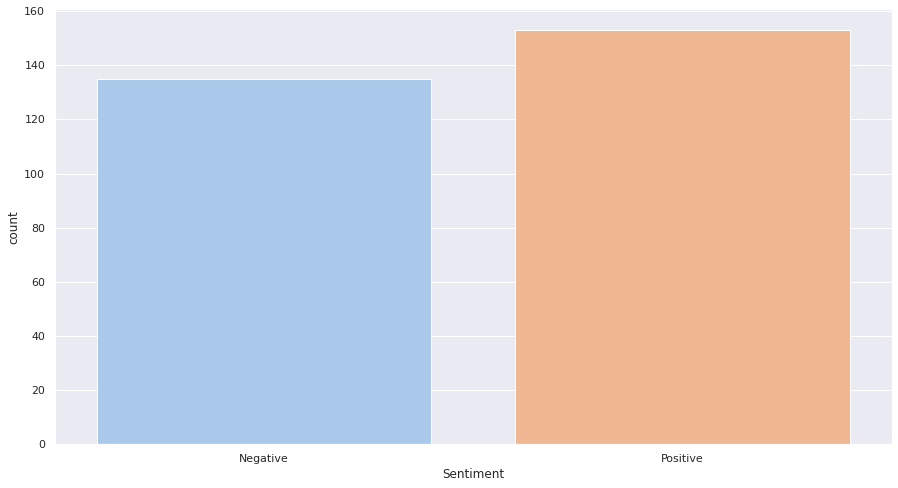

In [202]:
sns.countplot(data=df,x="Sentiment",palette="pastel");
print('Figure 6 showing results of Sentiment Application')

Further exploration of the data showed that most news sources we’re relatively balanced between their positive and negative sentiments as showing in Figure 7

In [203]:


# Preparing data for visualization 
Viz_1 = df[['Paper','Sentiment']].value_counts().rename_axis(['Paper','Sentiment']).reset_index(name='counts')

# Plotting the Bar Graph 
fig = px.bar(x=Viz_1.Paper, y=Viz_1.counts, color=Viz_1.Sentiment,color_discrete_sequence=px.colors.qualitative.Pastel,title="Sentiment & Ratings",labels={'x':'Paper','y':'Total Number'})
fig.show()
print("Figure 7 Sentiment scores by news source")

Figure 7 Sentiment scores by news source


Figure 8 by comparison shows that news directed at the local markets, classified as “state” tended to be more negatively skewed, which may suggest that newspapers target their articles towards their home markets in a bid to increase readership and subscriptions (Dimitrova, Markert, Otterbacher, & Piotrkowicz, 2017).

In [204]:

# Preparing data for visualization 
Viz_1 = df[['Section','Sentiment']].value_counts().rename_axis(['Section','Sentiment']).reset_index(name='counts')

# Plotting the Bar Graph 
fig = px.bar(x=Viz_1.Section, y=Viz_1.counts, color=Viz_1.Sentiment,color_discrete_sequence=px.colors.qualitative.Pastel,title="Sentiment & Ratings",labels={'x':'Section','y':'Total Number'})
fig.show()
print("Figure 8 Sentiment scores by newspaper section")

Figure 8 Sentiment scores by newspaper section


In [205]:
#Viz2 Data preparation 
Viz_2 = df['Paper'].value_counts().rename_axis(['Paper']).reset_index(name='counts')
    
# Plotting  pie chart for ratings
fig_pie = px.pie(values=Viz_2.counts, names=Viz_2.Paper, title='Rating Distribution of the data',color_discrete_sequence=px.colors.qualitative.Pastel)
fig_pie.show()

In [206]:
#Viz2 Data preparation 
Viz_2 = df['Section'].value_counts().rename_axis(['Section']).reset_index(name='counts')
    
# Plotting  pie chart for ratings
fig_pie = px.pie(values=Viz_2.counts, names=Viz_2.Section, title='Rating Distribution of the data',color_discrete_sequence=px.colors.qualitative.Pastel)
fig_pie.show()

The wordcloud generated on the positive and negative sentiments as shown in Figure 9, a word can be classified as both positive and negative if it is included in both dictionaries, or can be classified as neutral when it does not appear in either dictionary (Jagota, 2020). As outlined earlier, the sentiment result is the sum of the word scores in a given sentence, a limitation of the polarisation of results, is that words such as covid appear to be both positive and negative, when infact it’s assignment may be neutral.

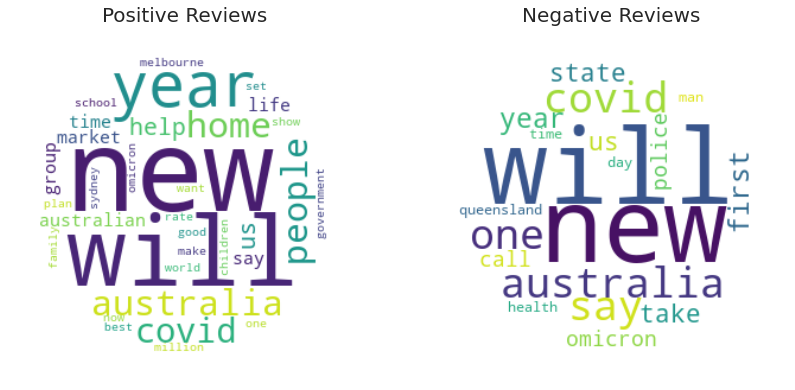

Figure 9 WordClouds for both the positive and negative groupings


In [207]:
# Getting all the reviews termed positive in a single string and forming a word cloud of the string
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14, 14], facecolor = None)

text1 =''
for i in df[df['Sentiment']=='Positive']['Together'].values:
    text1+=i + ' '

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc1 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc1.generate(text1)

ax1.axis("off")
ax1.imshow(wc1, interpolation="bilinear")
ax1.set_title('Positive Reviews',fontsize=20);

text2 =''
for i in df[df['Sentiment']=='Negative']['Together'].values:
    text2+=i + ' '

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)


wc2 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc2.generate(text2)

ax2.axis("off")
ax2.imshow(wc2, interpolation="bilinear")
ax2.set_title('Negative Reviews',fontsize=20);

plt.show()
print("Figure 9 WordClouds for both the positive and negative groupings")

##Machine Learning – Classification Tree

Decision trees are one of the foundations of data mining, and can be used for classification, it is a non-parametric supervised learning algorithm, that is it does not require a normally distributed dataset and requires a test and train dataset (HackerEarth, 2021). Relationship between words and features forms the basis of the extraction rules, each leaf node in the tree represents a property test, with the relevant branches capturing the pathways leading to and from the decisions (Bharathi & Suresh, 2016).  


###Preprocessing Data 
The cleaned corpus required additional pre-processing prior to the application of the topic model, 

	
*  Keywords from gensim.summarization are applied to the corpus
*  Removal of stop words 
*  Tokenisation of words reducing them to single words
*  Words are stemmed using porter-stemmer, that is the inflectional endings are removed.
*  Creation of the Dictionary that contains 2775 unique words. 


In [208]:
df["keywords"] = df["Together"].apply(keywords)
df["keywords"] = df["keywords"].astype("str").str.replace('\n',',') 

In [209]:
words = []
for x in df.keywords.values:
    x=x.split(",")
    for i in x:
        words.append(i)
words_blanks = filter(lambda x: x != "", words)
words = list(words_blanks)

In [210]:
from collections import Counter
word_counter = Counter(words)


print(word_counter)

Counter({'covid': 7, 'ashes': 6, 'vaccine': 4, 'home': 4, 'sector': 4, 'christmas': 3, 'higher': 3, 'office': 3, 'life': 3, 'government': 3, 'health': 3, 'family': 3, 'border': 3, 'school': 3, 'winter': 2, 'test': 2, 'starc': 2, 'live': 2, 'minister': 2, 'warns': 2, 'junkee': 2, 'year': 2, 'years': 2, 'raised': 2, 'rights': 2, 'power': 2, 'says': 2, 'energy': 2, 'vaccines': 2, 'media': 2, 'officer': 2, 'sporting': 2, 'crypto': 2, 'price': 2, 'prices': 2, 'saying': 2, 'jason': 2, 'league': 2, 'cummins': 2, 'australia': 2, 'accuser': 2, 'cabinet': 2, 'outage': 2, 'vaccinated': 2, 'like': 2, 'stock': 2, 'indigenous': 2, 'joins': 2, 'billion': 2, 'corporate': 2, 'markets': 2, 'bank': 2, 'gets': 2, 'big': 2, 'york': 2, 'housing': 2, 'data': 2, 'people': 2, 'man': 2, 'spinning': 2, 'groups': 2, 'news': 2, 'kids': 2, 'growers': 2, 'clothing': 2, 'children': 2, 'confirms': 1, 'confirmed': 1, 'olympicsthe': 1, 'zero': 1, 'panagiotopoulos': 1, 'ticked': 1, 'politics': 1, 'gladys': 1, 'liberal': 

In [211]:
# Python Counter
word_df = pd.DataFrame(np.array(list(word_counter.items())),columns=["keyword","count"])

In [212]:
# Top ten keywords
word_df["count"] = word_df["count"].astype(int)
word_df = word_df.sort_values(['count'], ascending=False)
top_10 = word_df[0:10]
word_df.head(10)

,keyword,count
12,covid,7
162,ashes,6
116,home,4
76,vaccine,4
209,sector,4
430,border,3
211,health,3
376,family,3
84,higher,3
19,christmas,3


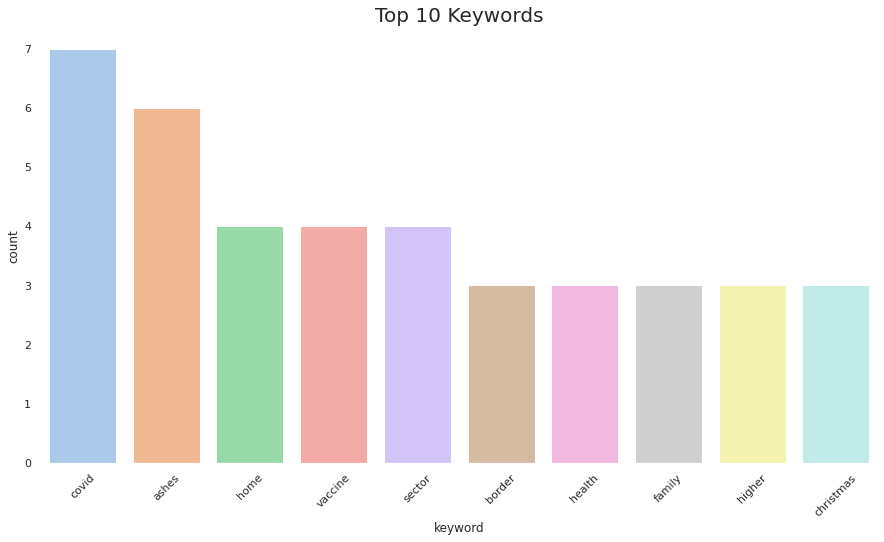

In [213]:
sns.set(rc={'figure.figsize':(15,8)})
fig, ax = plt.subplots()

ax = sns.barplot(data=top_10,x="keyword",y="count",palette="pastel")
ax.patch.set_visible(False)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_title("Top 10 Keywords",fontsize=20);

In [214]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [215]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'abc', 'australia', 'australian', 'year', 'aussies', 'news', 'day', 'be', 'use', 'be', 'get', 'say'])


words = ['from', 'abc', 'australia', 'australian', 'year', 'aussies', 'news', 'day', 'use', 'get', 'say', 'the', 'on', 'of']
for x in words:
    df["Together"] = df["Together"].astype(str).str.replace(x,"")

In [216]:
# Tokenisation

from gensim.utils import simple_preprocess
# Tokenize the text column to get the new column 'tokenized_text'
df['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in df['Together']] 
print(df['tokenized_text'].head(10))

0    [scott, morris, cfirms, diplomatic, boycott, b...
1    [desperate, triple, zero, calls, unanswered, a...
2    [live, nsw, omicr, covid, cluster, grows, firs...
3    [ashes, first, test, live, updates, root, dism...
4    [not, just, anor, alpha, male, how, pat, cummi...
5    [nathan, ly, and, subtleties, spin, will, be, ...
6    [want, to, attend, my, work, christmas, party,...
7    [hospital, drama, bursts, out, blocks, and, st...
8    [susan, orlean, comes, book, about, animals, e...
9    [liberal, elder, baird, encourages, berejiklia...
Name: tokenized_text, dtype: object


In [217]:
# Stemming

from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
# Get the stemmed_tokens
df['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in df['tokenized_text'] ]
df['stemmed_tokens'].head(10)

0    [scott, morri, cfirm, diplomat, boycott, beij,...
1    [desper, tripl, zero, call, unansw, as, life, ...
2    [live, nsw, omicr, covid, cluster, grow, first...
3    [ash, first, test, live, updat, root, dismiss,...
4    [not, just, anor, alpha, male, how, pat, cummi...
5    [nathan, ly, and, subtleti, spin, will, be, cr...
6    [want, to, attend, my, work, christma, parti, ...
7    [hospit, drama, burst, out, block, and, struck...
8    [susan, orlean, come, book, about, anim, excep...
9    [liber, elder, baird, encourag, berejiklian, t...
Name: stemmed_tokens, dtype: object

In [218]:
# Building a dictionary

from gensim import corpora
# Build the dictionary
mydict = corpora.Dictionary(df['stemmed_tokens'])
print("Total unique words:")
print(len(mydict.token2id))
print("\nSample data from dictionary:")
i = 0
# Print top 4 (word, id) tuples
for key in mydict.token2id.keys():
    print("Word: {} - ID: {} ".format(key, mydict.token2id[key]))
    if i == 3:
        break
    i += 1

Total unique words:
2767

Sample data from dictionary:
Word: beij - ID: 0 
Word: boycott - ID: 1 
Word: cfirm - ID: 2 
Word: diplomat - ID: 3 


##Application of the Decision Tree Classifier

The first step is to split the data into the test and train datasets, the sentiment becomes the Y variable, with Title, description, Section and Stemmed tokens the X using a 70/30 split with an even ratio of positive and negative sentiments.


In [219]:
# Splitting into train and test sets

from sklearn.model_selection import train_test_split
# Train Test Split Function
def split_train_test(df, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df[['Title', 'Description', 'Section', 'stemmed_tokens']], 
                                                        df['Sentiment'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df)

Value counts for Train sentiments
Negative    102
Positive     99
Name: Sentiment, dtype: int64
Value counts for Test sentiments
Positive    54
Negative    33
Name: Sentiment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index  ...                                     stemmed_tokens
0    115  ...  [told, her, wa, ghislain, maxwel, third, accr,...
1    250  ...  [everyth, you, need, to, know, ahead, first, a...
2    144  ...  [why, frydenberg, is, aim, for, full, how, tax...
3    187  ...  [wa, sport, minist, doubl, down, adelaid, ash,...
4    131  ...  [neoen, tesla, victorian, batteri, restart, af...

[5 rows x 5 columns]


TFIDF vectorisation is applied to the Corpus, this applies weighting to the words based on their frequency of appearance within documents before applying the classification model.

In [220]:
# Created TFIDF model

# Train the tfidf Model 
from gensim.models import TfidfModel
# Make sure the dictionary is created from the previous block
# BOW corpus is required for tfidf model
corpus = [mydict.doc2bow(line) for line in df['stemmed_tokens']]

# TF-IDF Model
tfidf_model = TfidfModel(corpus)

In [221]:
# Generating TFIDF vectors

import gensim

OUTPUT_FOLDER = '/content/drive/My Drive/Assessment_3/'
tfidf_filename = OUTPUT_FOLDER + 'train_review_tfidf.csv'
# Storing the tfidf vectors for training data in a file
vocab_len = len(mydict.token2id)
with open(tfidf_filename, 'w+') as tfidf_file:
    for index, row in X_train.iterrows():
        doc = mydict.doc2bow(row['stemmed_tokens'])
        features = gensim.matutils.corpus2csc([tfidf_model[doc]], num_terms=vocab_len).toarray()[:,0]
        if index == 0:
            header = ",".join(str(mydict[ele]) for ele in range(vocab_len))
            print(header)
            print(tfidf_model[doc])
            tfidf_file.write(header)
            tfidf_file.write("\n")
        line1 = ",".join( [str(vector_element) for vector_element in features] )
        tfidf_file.write(line1)
        tfidf_file.write('\n')


beij,boycott,cfirm,diplomat,ficial,ha,minist,morri,not,olymp,prime,scott,send,to,upcom,will,winter,ambul,an,as,awayvictoria,but,call,desper,in,is,life,nick,octob,panagiotopoulo,seamlessli,servic,someth,suppos,terribl,tick,tri,tripl,unansw,went,when,work,wrg,zero,and,ash,begin,berejiklian,brisbaneanor,chang,china,cluster,coraviru,covid,down,elder,encourag,feder,first,for,gladi,grow,isn,liber,live,nsw,omicr,outbreak,polit,run,shape,slow,test,victoria,after,ar,at,ball,dismiss,dream,duck,gabba,mitchel,root,seri,starc,start,strike,took,updat,wicket,with,about,all,alpha,anor,be,been,captain,could,cricket,cummin,given,grace,hi,how,into,job,just,male,men,never,new,pat,save,that,walk,bat,ben,best,brilliant,crucial,deep,dive,examin,fourth,ly,might,nathan,part,quell,showdown,spin,stoke,stokesin,stop,strategi,subtleti,we,allow,attend,bad,christma,do,ever,expect,freedom,moveif,my,parti,rar,re,than,thi,think,time,want,what,you,yourself,aim,america,amsterdam,block,broken,burst,covidnew,drama,episod,e


The classification tree is applied to the training set Y using the default settings, and the most important features are identified as shown in Figure 11.


In [222]:
# Training sentiment classification model using tfidf vectors

from sklearn.tree import DecisionTreeClassifier


# Read the TFIDF vectors
tfidf_df = pd.read_csv('/content/drive/My Drive/Assessment_3/train_review_tfidf.csv')

# Initialize the model
clf_decision_tfidf = DecisionTreeClassifier(random_state=2)

# Fit the model 
clf_decision_tfidf.fit(tfidf_df, Y_train['Sentiment'])



DecisionTreeClassifier(random_state=2)

In [223]:
# Find out the most important features from the tfidf classification model

importances = list(clf_decision_tfidf.feature_importances_)
feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(tfidf_df.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# print(feature_importances)
top_i = 0
for pair in feature_importances:
    print('Variable: {:10} Importance: {}'.format(*pair))
    if top_i == 10:
        break
    top_i += 1

Variable: first      Importance: 0.0531167742
Variable: for        Importance: 0.0406974526
Variable: when       Importance: 0.037682183
Variable: state      Importance: 0.0366574518
Variable: big        Importance: 0.035968459
Variable: pai        Importance: 0.0343005175
Variable: do         Importance: 0.0342700987
Variable: ha         Importance: 0.0332502836
Variable: highli     Importance: 0.0332031201
Variable: best       Importance: 0.0326686004
Variable: ash        Importance: 0.0318793045


### Applying the classification model to the test dataset

The results of the applied model in Figure 12 show that the model was not highly successful in the classification of the data, 


*   Precision – Count of every item that was correctly identified as positive, a high precision score indicates a robust model (Korstanje, 2021), the resulting precision scores for this model are relatively inaccurate, which may be reflective of the small dataset.
*  Recall – Count of the number of successful identified positives from all positives within the dataset (Korstanje, 2021) Again this model performs poorly with outcomes just as likely to be incorrectly classified.
*   F1 Score – combines the precision and recall and provides a mean result, the F1 score works well for imbalanced datasets and combines the precision and recall into a single metric (Korstanje, 2021). As expected the F1 score reflects the poor performance of the model. 


In [224]:
# Testing the model

from sklearn.metrics import classification_report
test_features_tfidf = []
import time
start_time = time.time()
for index, row in X_test.iterrows():
    doc = mydict.doc2bow(row['stemmed_tokens'])
    features = gensim.matutils.corpus2csc([tfidf_model[doc]], num_terms=vocab_len).toarray()[:,0]
    test_features_tfidf.append(features)
test_predictions_tfidf = clf_decision_tfidf.predict(test_features_tfidf)
print(classification_report(Y_test['Sentiment'],test_predictions_tfidf))


              precision    recall  f1-score   support

    Negative       0.33      0.39      0.36        33
    Positive       0.57      0.50      0.53        54

    accuracy                           0.46        87
   macro avg       0.45      0.45      0.45        87
weighted avg       0.48      0.46      0.47        87



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



##Final remarks:


This analysis shows that the implementation of the model on the titles and descriptions was not a robust model that produces accurate results, it does however show that for the state based news articles, the language used tends to be more negatively skewed which supports the original premise that the drive for ‘clicks’ skews headlines towards negative sentimentality (Charagulla, Jayant, & Kumar, 2021). 

Increased access to digital news, particularly through mobile devices along with newspapers becoming a trusted source of health information relating to covid as communicated through the Digital News Report (Andi, et al., 2021), along with negative impacts to mental health in the wake of covid-19 (Kathirve, 2020) suggest more focus should be put on the underlying sentiments presented in news headlines and descriptions to reduce potential negative emotional reactions such as increased anxiety and depression.
